In [ ]:
pip install numpy pandas scipy matplotlib

Optimal Portfolio Weights: [0.33333333 0.33333333 0.33333333]
Expected Portfolio Return: 758.2072289156628
Portfolio Variance (Risk): 7931.647669306258
Maximum Possible Portfolio Risk (at 40% per asset): 11421.572643801008
Risk Percentage of Portfolio: 69.44444444444446 %


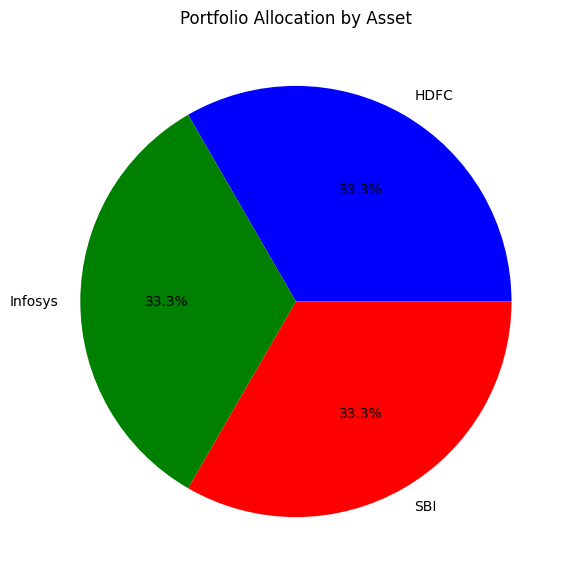

In [ ]:
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Define paths for datasets
hdfc_path = 'Hdfc.csv'
infosys_path = 'infosys.csv'
sbi_path = 'sbi.csv'

# Load stock data for each asset and strip any spaces in column names
hdfc_data = pd.read_csv(hdfc_path)
infosys_data = pd.read_csv(infosys_path)
sbi_data = pd.read_csv(sbi_path)

hdfc_data.columns = hdfc_data.columns.str.strip()
infosys_data.columns = infosys_data.columns.str.strip()
sbi_data.columns = sbi_data.columns.str.strip()

# Define the expected date format
date_format = '%d-%b-%y'

# Ensure 'Date' column exists and is in the specified format, clean 'Return' columns
for df, name in zip([hdfc_data, infosys_data, sbi_data], ['HDFC', 'Infosys', 'SBI']):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], format=date_format, errors='coerce')
        if df['Return'].dtype == 'object':
            df['Return'] = pd.to_numeric(df['Return'].str.replace(',', ''), errors='coerce')
    else:
        print(f"Error: 'Date' column missing in {name} data")

# Proceed only if 'Date' columns exist in all datasets
if 'Date' in hdfc_data.columns and 'Date' in infosys_data.columns and 'Date' in sbi_data.columns:
    # Merge datasets by 'Date' column to align all stocks
    merged_data = hdfc_data.merge(infosys_data, on='Date', suffixes=('_hdfc', '_infosys'))
    merged_data = merged_data.merge(sbi_data, on='Date', suffixes=('', '_sbi'))

    # Extract aligned return columns and drop any NaN values
    hdfc_returns = merged_data['Return'].dropna()
    infosys_returns = merged_data['Return'].dropna()
    sbi_returns = merged_data['Return'].dropna()

    # Truncate to the minimum length of available data to align all three series
    min_length = min(len(hdfc_returns), len(infosys_returns), len(sbi_returns))
    hdfc_returns = hdfc_returns[:min_length]
    infosys_returns = infosys_returns[:min_length]
    sbi_returns = sbi_returns[:min_length]

    # Combine returns into a matrix for portfolio optimization
    returns = np.array([hdfc_returns, infosys_returns, sbi_returns]).T

    # Calculate expected returns and covariance matrix
    exp_returns = np.mean(returns, axis=0)
    covariance_matrix = np.cov(returns, rowvar=False)

    # Set up quadratic programming problem
    n = len(exp_returns)  # number of assets

    # Quadratic term (covariance matrix)
    P = matrix(covariance_matrix)

    # Linear term (expected returns for maximizing/minimizing return; here we'll keep it neutral)
    q = matrix(np.zeros(n))

    # Constraints: weights must sum to 1
    G = matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = matrix(np.hstack((np.zeros(n), 0.4 * np.ones(n))))  # Limit each asset to 40% max

    # Equality constraint to force the sum of weights to 1
    A = matrix(1.0, (1, n))
    b = matrix(1.0)

    # Solve the quadratic program
    solvers.options['show_progress'] = False
    result = solvers.qp(P, q, G, h, A, b)

    # Extract and display the results
    weights = np.array(result['x']).flatten()
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    print("Optimal Portfolio Weights:", weights)
    print("Expected Portfolio Return:", np.dot(weights, exp_returns))
    print("Portfolio Variance (Risk):", portfolio_variance)

    # Calculate the maximum possible risk if each asset is invested at 40%
    max_weights = 0.4 * np.ones(n)
    max_risk = np.dot(max_weights.T, np.dot(covariance_matrix, max_weights))
    risk_percentage = (portfolio_variance / max_risk) * 100

    print("Maximum Possible Portfolio Risk (at 40% per asset):", max_risk)
    print("Risk Percentage of Portfolio:", risk_percentage, "%")

    # Plotting the weights for visualization
    asset_names = ['HDFC', 'Infosys', 'SBI']

    # Pie chart for asset allocation ratios
    plt.figure(figsize=(7, 7))
    plt.pie(weights, labels=asset_names, autopct='%1.1f%%', colors=['blue', 'green', 'red'])
    plt.title('Portfolio Allocation by Asset')
    plt.show()

else:
    print("Cannot proceed with optimization; data merge unsuccessful.")
